# Backtest Complete Portfolio (Long-Term + Short-Term) Straty 
This notebook demonstrates how to backtest a portfolio strategy using the `bt` library in Python. The strategy is based on the Markowitz Mean-Variance Optimization approach, which aims to maximize returns while minimizing risk.

### **Step 1: Import Libraries** 

In [2]:
# UDFs
from py.utils import load_and_filter_data

# System libraries
import glob
import os
import sys
from io import StringIO
from typing import Dict, List

# Data manipulation libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pandas.tseries.offsets import BDay

# Plotting libraries
import matplotlib.pyplot as plt

# Backtesting library
import bt

### **Step 2: Define Parameters**

#### Date Range

In [3]:
# Define the date range
end_date = (datetime.today() - BDay(1)).to_pydatetime()  # Subtract 1 business day
start_date = end_date - timedelta(days=10*365)

# Print the date range
days_difference = (end_date - start_date).days
print(f"Date Range: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
print(f"Time span: {days_difference} days ({days_difference/365:.2f} years)")

Date Range: 2015-06-07 to 2025-06-04
Time span: 3650 days (10.00 years)


#### Risk-free rate (T-bill, %)

In [4]:
daily_risk_free_df = load_and_filter_data('data/daily_treasury_rates.csv', ['^IRX'], start_date, end_date)
# risk_free_rate = .0433
risk_free_rate = daily_risk_free_df.iloc[-1, 0] / 100

last_risk_free_df = daily_risk_free_df \
    .sort_index(axis=0, ascending=False) \
    .head(1) \
    .reset_index() \
    .melt(id_vars='Date', value_vars=['^IRX'])

last_risk_free_df.set_index('Date', inplace=True)
last_risk_free_df.rename(columns={'value': 'Close', 'variable': 'Ticker'}, inplace=True)

print("Risk-Free Rate:", risk_free_rate, "-- 13 WEEK TREASURY BILL (^IRX)")

Found 1 of 1 tickers in data/daily_treasury_rates.csv
Missing tickers: []
Risk-Free Rate: 0.0424 -- 13 WEEK TREASURY BILL (^IRX)


#### Portfolio Data

In [5]:
# Get the most recent portfolio file
portfolio_files = glob.glob('portfolios/portfolio-*.xlsx')
if portfolio_files:
    # Sort files by modification time (most recent first)
    output_file = max(portfolio_files, key=os.path.getmtime)
    print(f"Using most recent portfolio file: {output_file}")
else:
    # Fallback to current date if no files found
    output_file = f'portfolios/portfolio-{datetime.date(end_date)}.xlsx'
    print(f"No portfolio files found. Using: {output_file}")

Using most recent portfolio file: portfolios/portfolio-2025-06-04.xlsx


#### Assign Weights

In [6]:
long_term_portfolio_df = pd.read_excel(output_file, sheet_name='long_term')
short_term_portfolio_df = pd.read_excel(output_file, sheet_name='short_term')

# Load benchmark data
benchmark_long_term_df = pd.read_excel(output_file, sheet_name='benchmark_long_term')
benchmark_short_term_df = pd.read_excel(output_file, sheet_name='benchmark_short_term')

# Extract benchmark tickers
long_term_benchmarks = benchmark_long_term_df['Benchmark'].tolist()
short_term_benchmarks = benchmark_short_term_df['Benchmark'].tolist()

# Combine all unique benchmarks
all_benchmarks = list(set(long_term_benchmarks + short_term_benchmarks))

print(f"Long-term benchmarks: {long_term_benchmarks}")
print(f"Short-term benchmarks: {short_term_benchmarks}")
print(f"All benchmarks: {all_benchmarks}")

long_term_pf_weight = 1.00
short_term_pf_weight = 1.00

# Apply portfolio weights to the DataFrames before combining
long_term_portfolio_df['Weight'] = long_term_portfolio_df['Weight'] * long_term_pf_weight
short_term_portfolio_df['Weight'] = short_term_portfolio_df['Weight'] * short_term_pf_weight

# Now create the weights dictionaries and DataFrames
long_term_weights_df = long_term_portfolio_df[['Ticker', 'Weight']]
short_term_weights_df = short_term_portfolio_df[['Ticker', 'Weight']]

long_term_weights = dict(zip(long_term_weights_df['Ticker'], long_term_weights_df['Weight']))
short_term_weights = dict(zip(short_term_weights_df['Ticker'], short_term_weights_df['Weight']))

# Combine the adjusted portfolios
combined_portfolio_df = pd.concat([long_term_portfolio_df, short_term_portfolio_df], ignore_index=True)
weights_df = combined_portfolio_df[['Ticker', 'Weight']]
tickers = combined_portfolio_df['Ticker'].unique()

# Add benchmarks to tickers list for data loading
tickers = list(set(list(tickers) + all_benchmarks))

weights = dict(zip(weights_df['Ticker'], weights_df['Weight']))
print(weights)
display(combined_portfolio_df)

Long-term benchmarks: ['PCEF', 'PCEF', 'PCEF', 'PCEF', 'PCEF', 'PCEF']
Short-term benchmarks: ['DSI', 'DSI']
All benchmarks: ['PCEF', 'DSI']
{'MMC': 0.304185034385935, 'AMAT': 0.2262441160445363, 'TMUS': 0.1953223567175497, 'MRK': 0.1508982223923648, 'APO': 0.06409846385733795, 'PG': 0.05925180660227629, 'GRMN': 0.5, 'MSFT': 0.5}


,Ticker,Date,Name,Sector,Industry,Country,Website,Market Cap,Enterprise Value,Float Shares,...,Volatility,Short Period,Long Period,Articles In Last Week,Company News Score,Bearish Percent,Bullish Percent,Average Sentiment Score,Sector Average Bullish Percent,Sector Average News Score
0,MMC,2025-06-02,"Marsh & McLennan Companies, Inc.",Financial Services,Insurance Brokers,United States,https://www.marshmclennan.com,115130826752,136148770816,491821141,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AMAT,2025-06-02,"Applied Materials, Inc.",Technology,Semiconductor Equipment & Materials,United States,https://www.appliedmaterials.com,125791559680,125714595840,799392549,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TMUS,2025-06-02,"T-Mobile US, Inc.",Communication Services,Telecom Services,United States,https://www.t-mobile.com,275005997056,384693796864,452736028,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MRK,2025-06-02,"Merck & Co., Inc.",Healthcare,Drug Manufacturers - General,United States,https://www.merck.com,192947535872,218628636672,2507088934,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,APO,2025-06-02,"Apollo Global Management, Inc.",Financial Services,Asset Management,United States,https://www.apollo.com/institutional/homepage,74688552960,94705582080,446479870,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,PG,2025-06-02,The Procter & Gamble Company,Consumer Defensive,Household & Personal Products,United States,https://www.pginvestor.com,398313881600,424393244672,2341001776,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,GRMN,2025-06-02,Garmin Ltd.,Technology,Scientific & Technical Instruments,Switzerland,https://www.garmin.com,39080046592,36584062976,174794910,...,0.249911,10.0,190.0,7.0,0.6018,0.0000,0.4286,0.2036,0.4848,0.566
7,MSFT,2025-06-02,Microsoft Corporation,Technology,Software - Infrastructure,United States,https://www.microsoft.com,3421643997184,3447046799360,7422063978,...,0.267651,30.0,190.0,37.0,0.6028,0.0541,0.5405,0.2057,0.4848,0.566


#### **Step 3: Import Stock Data**

In [7]:
data = load_and_filter_data('data/daily_quotes.csv', tickers, start_date, end_date)
data.head()

Found 10 of 10 tickers in data/daily_quotes.csv
Missing tickers: []


,AMAT,APO,DSI,GRMN,MMC,MRK,MSFT,PCEF,PG,TMUS
Date,,,,,,,,,,
2015-06-08,17.62,13.98,33.57,33.57,48.77,41.36,39.65,10.67,58.83,38.61
2015-06-09,17.65,13.50,33.54,33.75,48.96,41.34,39.58,10.62,59.74,37.93
2015-06-10,17.77,13.53,33.97,34.28,49.75,41.88,40.42,10.64,60.22,37.81
2015-06-11,17.54,13.56,34.04,33.98,50.15,41.70,40.27,10.67,60.12,37.28
2015-06-12,17.40,13.48,33.84,33.44,49.96,40.96,39.86,10.64,59.71,38.14


#### Split Data into Training and Testing Sets

In [8]:
total_rows = len(data)
train_size = int(0.8 * total_rows)
training_set = data.iloc[:train_size]
test_set = data.iloc[train_size:]

print(f"Training: {len(training_set)} rows ({len(training_set)/total_rows:.1%}) | Testing: {len(test_set)} rows ({len(test_set)/total_rows:.1%})")
print(f"Training period: {training_set.index[0]} to {training_set.index[-1]}")
print(f"Testing period: {test_set.index[0]} to {test_set.index[-1]}")

Training: 2005 rows (80.0%) | Testing: 502 rows (20.0%)
Training period: 2015-06-08 00:00:00 to 2023-05-23 00:00:00
Testing period: 2023-05-24 00:00:00 to 2025-05-23 00:00:00


#### **Step 4: Create & Backtest Strategy**

In [9]:
# First, let's examine what strategies and periods are available in the portfolio
print("Portfolio strategies and periods:")
strategy_info = combined_portfolio_df[['Ticker', 'Strategy', 'Short Period', 'Long Period', 'Weight']].dropna(subset=['Strategy'])
display(strategy_info)

# Initialize dictionaries to store moving averages and signals
sma_data_short = {}
sma_data_long = {}
ema_data_short = {}
ema_data_long = {}
static_weights = {}

# Calculate moving averages for each ticker based on their strategy and periods
for _, row in strategy_info.iterrows():
    ticker = row['Ticker']
    strategy = row['Strategy']
    short_period = int(row['Short Period'])
    long_period = int(row['Long Period'])
    
    if ticker in data.columns:
        if strategy.upper() == 'SMA':
            # Calculate SMAs
            sma_data_short[ticker] = data[ticker].rolling(window=short_period).mean()
            sma_data_long[ticker] = data[ticker].rolling(window=long_period).mean()
        elif strategy.upper() == 'EMA':
            # Calculate EMAs
            ema_data_short[ticker] = data[ticker].ewm(span=short_period).mean()
            ema_data_long[ticker] = data[ticker].ewm(span=long_period).mean()

# Handle tickers without strategy (static weights)
static_tickers = combined_portfolio_df[combined_portfolio_df['Strategy'].isna()]
for _, row in static_tickers.iterrows():
    ticker = row['Ticker']
    weight = row['Weight']
    if ticker in data.columns:
        static_weights[ticker] = weight

# Convert dictionaries to DataFrames
sma_short = pd.DataFrame(sma_data_short, index=data.index) if sma_data_short else pd.DataFrame()
sma_long = pd.DataFrame(sma_data_long, index=data.index) if sma_data_long else pd.DataFrame()
ema_short_df = pd.DataFrame(ema_data_short, index=data.index) if ema_data_short else pd.DataFrame()
ema_long_df = pd.DataFrame(ema_data_long, index=data.index) if ema_data_long else pd.DataFrame()

# Create target weights based on signals
# Initialize with zeros for all tickers
all_target_weights = pd.DataFrame(0.0, index=data.index, columns=tickers)

# Apply SMA signals
if not sma_short.empty:
    for ticker in sma_short.columns:
        # Get the weight for this ticker from the portfolio
        ticker_weight = combined_portfolio_df[combined_portfolio_df['Ticker'] == ticker]['Weight'].iloc[0]
        
        # Apply SMA crossover signals
        all_target_weights[ticker] = np.where(
            sma_short[ticker] > sma_long[ticker], 
            ticker_weight,  # Long position with portfolio weight
            -ticker_weight  # Short position with portfolio weight
        )

# Apply EMA signals
if not ema_short_df.empty:
    for ticker in ema_short_df.columns:
        # Get the weight for this ticker from the portfolio
        ticker_weight = combined_portfolio_df[combined_portfolio_df['Ticker'] == ticker]['Weight'].iloc[0]
        
        # Apply EMA crossover signals
        all_target_weights[ticker] = np.where(
            ema_short_df[ticker] > ema_long_df[ticker], 
            ticker_weight,  # Long position with portfolio weight
            -ticker_weight  # Short position with portfolio weight
        )

# Apply static weights for tickers without signals
for ticker, weight in static_weights.items():
    all_target_weights[ticker] = weight

# Create merged data for plotting
plot_data = []
plot_titles = []

if not sma_short.empty:
    sma_target_weights = all_target_weights[sma_short.columns]
    sma_tmp = bt.merge(sma_target_weights, data[sma_short.columns], sma_short, sma_long)
    
    # Create column names for SMA plot
    sma_tickers = list(sma_short.columns)
    sma_weight_columns = [f'{ticker} Weights' for ticker in sma_tickers]
    sma_price_columns = [f'{ticker} Price' for ticker in sma_tickers]
    sma_short_columns = [f'{ticker} SMA{int(strategy_info[strategy_info["Ticker"]==ticker]["Short Period"].iloc[0])}' 
                        for ticker in sma_tickers]
    sma_long_columns = [f'{ticker} SMA{int(strategy_info[strategy_info["Ticker"]==ticker]["Long Period"].iloc[0])}' 
                       for ticker in sma_tickers]
    
    sma_tmp.columns = sma_weight_columns + sma_price_columns + sma_short_columns + sma_long_columns
    plot_data.append(('SMA', sma_tmp, sma_weight_columns, sma_tickers))

if not ema_short_df.empty:
    ema_target_weights = all_target_weights[ema_short_df.columns]
    ema_tmp = bt.merge(ema_target_weights, data[ema_short_df.columns], ema_short_df, ema_long_df)
    
    # Create column names for EMA plot
    ema_tickers = list(ema_short_df.columns)
    ema_weight_columns = [f'{ticker} Weights' for ticker in ema_tickers]
    ema_price_columns = [f'{ticker} Price' for ticker in ema_tickers]
    ema_short_columns = [f'{ticker} EMA{int(strategy_info[strategy_info["Ticker"]==ticker]["Short Period"].iloc[0])}' 
                        for ticker in ema_tickers]
    ema_long_columns = [f'{ticker} EMA{int(strategy_info[strategy_info["Ticker"]==ticker]["Long Period"].iloc[0])}' 
                       for ticker in ema_tickers]
    
    ema_tmp.columns = ema_weight_columns + ema_price_columns + ema_short_columns + ema_long_columns
    plot_data.append(('EMA', ema_tmp, ema_weight_columns, ema_tickers))

# Find crossover points and create plots
if plot_data:
    fig, axes = plt.subplots(len(plot_data), 1, figsize=(15, 6*len(plot_data)))
    if len(plot_data) == 1:
        axes = [axes]
    
    for plot_idx, (strategy_type, tmp_data, weight_columns, strategy_tickers) in enumerate(plot_data):
        ax = axes[plot_idx]
        
        # Plot the data
        tmp_data.plot(ax=ax, secondary_y=weight_columns)
        ax.set_title(f'{strategy_type} Strategy: Target Weights and Moving Averages')
        ax.set_xlabel('Date')
        ax.set_ylabel('Price')
        ax.right_ax.set_ylabel('Weights')
        
        # Move legends outside the plot area
        ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
        ax.right_ax.legend(loc='upper left', bbox_to_anchor=(1.05, 0.65))
        
        # Find and annotate crossovers
        for ticker in strategy_tickers:
            crossovers = []
            signals = []
            
            # Get periods for this ticker
            ticker_info = strategy_info[strategy_info['Ticker'] == ticker].iloc[0]
            short_period = int(ticker_info['Short Period'])
            long_period = int(ticker_info['Long Period'])
            
            short_col = f'{ticker} {strategy_type}{short_period}'
            long_col = f'{ticker} {strategy_type}{long_period}'
            price_col = f'{ticker} Price'
            
            for i in range(1, len(tmp_data)):
                # Check for bullish crossover (short MA crosses above long MA)
                if (tmp_data[short_col].iloc[i-1] <= tmp_data[long_col].iloc[i-1] and 
                    tmp_data[short_col].iloc[i] > tmp_data[long_col].iloc[i]):
                    crossovers.append(tmp_data.index[i])
                    signals.append('Long')
                # Check for bearish crossover (short MA crosses below long MA)
                elif (tmp_data[short_col].iloc[i-1] >= tmp_data[long_col].iloc[i-1] and 
                      tmp_data[short_col].iloc[i] < tmp_data[long_col].iloc[i]):
                    crossovers.append(tmp_data.index[i])
                    signals.append('Short')
            
            # Add crossover annotations
            for date, signal in zip(crossovers, signals):
                price_at_crossover = tmp_data.loc[date, price_col]
                color = 'green' if signal == 'Long' else 'red'
                
                ax.annotate(f'{ticker} {signal}', 
                           xy=(date, price_at_crossover), 
                           xytext=(10, 20 if signal == 'Long' else -30),
                           textcoords='offset points',
                           bbox=dict(boxstyle='round,pad=0.3', facecolor=color, alpha=0.7),
                           arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', color=color),
                           fontsize=8,
                           color='white',
                           weight='bold')
    
    plt.tight_layout()
    plt.show()
else:
    print("No trading signals found in the portfolio data.")

# Store the final target weights for backtesting
final_target_weights = all_target_weights
print("\nFinal target weights created using portfolio-specific strategies and periods.")
print(f"SMA tickers: {list(sma_short.columns) if not sma_short.empty else 'None'}")
print(f"EMA tickers: {list(ema_short_df.columns) if not ema_short_df.empty else 'None'}")
print(f"Static tickers: {list(static_weights.keys()) if static_weights else 'None'}")

Portfolio strategies and periods:


,Ticker,Strategy,Short Period,Long Period,Weight
6,GRMN,SMA_Cross_Signal,10.0,190.0,0.5
7,MSFT,SMA_Cross_Signal,30.0,190.0,0.5


No trading signals found in the portfolio data.

Final target weights created using portfolio-specific strategies and periods.
SMA tickers: None
EMA tickers: None
Static tickers: ['MMC', 'AMAT', 'TMUS', 'MRK', 'APO', 'PG']


#### Master Strategy

In [10]:
# Create strategies based on what's available in the portfolio
strategies_to_run = []
strategy_names = []

# SMA Strategy (if SMA tickers exist)
if not sma_short.empty:
    # Get unique periods for strategy naming
    sma_periods = strategy_info[strategy_info['Strategy'].str.upper() == 'SMA'][['Short Period', 'Long Period']].drop_duplicates()
    if len(sma_periods) == 1:
        short_p, long_p = int(sma_periods.iloc[0]['Short Period']), int(sma_periods.iloc[0]['Long Period'])
        strategy_name = f'SMA Strategy ({short_p}-{long_p})'
    else:
        strategy_name = 'SMA Strategy (Mixed Periods)'
    
    sma_strategy = bt.Strategy(strategy_name, [
        bt.algos.RunWeekly(),  # Run weekly for more responsive signals
        bt.algos.WeighTarget(all_target_weights[sma_short.columns]),
        bt.algos.Rebalance()])
    
    strategies_to_run.append(bt.Backtest(sma_strategy, test_set))
    strategy_names.append(strategy_name)

# EMA Strategy (if EMA tickers exist)
if not ema_short_df.empty:
    # Get unique periods for strategy naming
    ema_periods = strategy_info[strategy_info['Strategy'].str.upper() == 'EMA'][['Short Period', 'Long Period']].drop_duplicates()
    if len(ema_periods) == 1:
        short_p, long_p = int(ema_periods.iloc[0]['Short Period']), int(ema_periods.iloc[0]['Long Period'])
        strategy_name = f'EMA Strategy ({short_p}-{long_p})'
    else:
        strategy_name = 'EMA Strategy (Mixed Periods)'
    
    ema_strategy = bt.Strategy(strategy_name, [
        bt.algos.RunWeekly(),  # Run weekly for more responsive signals
        bt.algos.WeighTarget(all_target_weights[ema_short_df.columns]),
        bt.algos.Rebalance()])
    
    strategies_to_run.append(bt.Backtest(ema_strategy, test_set))
    strategy_names.append(strategy_name)

# Combined Signal Strategy (uses all target weights including static)
combined_signal_strategy = bt.Strategy('Combined Signal Strategy', [
    bt.algos.RunWeekly(),
    bt.algos.WeighTarget(final_target_weights),
    bt.algos.Rebalance()])

strategies_to_run.append(bt.Backtest(combined_signal_strategy, test_set))
strategy_names.append('Combined Signal Strategy')

# Long-Term Strategy (static weights, rebalanced every 66 days)
long_term_strategy = bt.Strategy('Long Term Strategy', 
                                [
                                    bt.algos.RunEveryNPeriods(66, offset=66),
                                    bt.algos.SelectAll(),
                                    bt.algos.WeighSpecified(**long_term_weights),
                                    bt.algos.Rebalance()
                                ])

# Short-Term Strategy (static weights, rebalanced weekly)
short_term_strategy = bt.Strategy('Short Term Strategy', 
                                 [
                                     bt.algos.RunWeekly(),
                                     bt.algos.SelectAll(),
                                     bt.algos.WeighSpecified(**short_term_weights),
                                     bt.algos.Rebalance()
                                 ])

# Master Strategy combining static long/short-term strategies
master_strategy = bt.Strategy('Master Strategy',
                             [
                                 bt.algos.RunWeekly(),
                                 bt.algos.SelectAll(),
                                 bt.algos.WeighSpecified(**{
                                     'Long Term Strategy': 0.85,
                                     'Short Term Strategy': 0.15
                                 }),
                                 bt.algos.Rebalance()
                             ],
                             children=[long_term_strategy, short_term_strategy])
test1 = bt.Backtest(master_strategy, test_set)

#### Benchmark Strategy

In [11]:
# Create Benchmark Strategies
benchmark_strategies = []

# Long-Term Benchmark Strategy
if long_term_benchmarks:
    # Filter benchmarks that exist in the test data and remove duplicates
    available_long_benchmarks = list(set([ticker for ticker in long_term_benchmarks if ticker in test_set.columns]))
    
    if available_long_benchmarks:
        # Create equal weights for available benchmarks
        long_term_benchmark_weights = {ticker: 1.0/len(available_long_benchmarks) for ticker in available_long_benchmarks}
        
        long_term_benchmark_strategy = bt.Strategy('Long Term Benchmark', [
            bt.algos.RunEveryNPeriods(66, offset=66),  # Same rebalancing frequency as long-term strategy
            bt.algos.SelectAll(),
            bt.algos.WeighSpecified(**long_term_benchmark_weights),
            bt.algos.Rebalance()
        ])
        
        # Select only unique columns for the benchmark data
        long_term_benchmark_data = test_set[available_long_benchmarks].copy()
        benchmark_strategies.append(bt.Backtest(long_term_benchmark_strategy, long_term_benchmark_data))
        print(f"Long Term Benchmark created with tickers: {available_long_benchmarks}")
    else:
        print("No long-term benchmark tickers found in test data")

# Short-Term Benchmark Strategy
if short_term_benchmarks:
    # Filter benchmarks that exist in the test data and remove duplicates
    available_short_benchmarks = list(set([ticker for ticker in short_term_benchmarks if ticker in test_set.columns]))
    
    if available_short_benchmarks:
        # Create equal weights for available benchmarks
        short_term_benchmark_weights = {ticker: 1.0/len(available_short_benchmarks) for ticker in available_short_benchmarks}
        
        short_term_benchmark_strategy = bt.Strategy('Short Term Benchmark', [
            bt.algos.RunWeekly(),  # Same rebalancing frequency as short-term strategy
            bt.algos.SelectAll(),
            bt.algos.WeighSpecified(**short_term_benchmark_weights),
            bt.algos.Rebalance()
        ])
        
        # Select only unique columns for the benchmark data
        short_term_benchmark_data = test_set[available_short_benchmarks].copy()
        benchmark_strategies.append(bt.Backtest(short_term_benchmark_strategy, short_term_benchmark_data))
        print(f"Short Term Benchmark created with tickers: {available_short_benchmarks}")
    else:
        print("No short-term benchmark tickers found in test data")

# Combined Benchmark Strategy (if both benchmarks exist)
if len(benchmark_strategies) == 2:
    # Create a combined benchmark that mirrors the master strategy allocation
    combined_benchmark_strategy = bt.Strategy('Combined Benchmark',
                                            [
                                                bt.algos.RunWeekly(),
                                                bt.algos.SelectAll(),
                                                bt.algos.WeighSpecified(**{
                                                    'Long Term Benchmark': 0.85,
                                                    'Short Term Benchmark': 0.15
                                                }),
                                                bt.algos.Rebalance()
                                            ],
                                            children=[benchmark_strategies[0].strategy, benchmark_strategies[1].strategy])
    
    benchmark_strategies.append(bt.Backtest(combined_benchmark_strategy, test_set))
    print("Combined Benchmark strategy created")

# Create main strategy backtest
test1 = bt.Backtest(master_strategy, test_set)
test2 = bt.Backtest(combined_benchmark_strategy, test_set)

# Combine all strategies for comparison
all_strategies = [test1] + benchmark_strategies + strategies_to_run

print(f"\nTotal strategies created: {len(all_strategies)}")
print("Strategy list:")
for i, strategy in enumerate(all_strategies):
    print(f"{i+1}. {strategy.strategy.name}")

Long Term Benchmark created with tickers: ['PCEF']
Short Term Benchmark created with tickers: ['DSI']
Combined Benchmark strategy created

Total strategies created: 5
Strategy list:
1. Master Strategy
2. Long Term Benchmark
3. Short Term Benchmark
4. Combined Benchmark
5. Combined Signal Strategy


#### **Step 5: Run Backtest**

In [12]:
res1 = bt.run(test1)
res2 = bt.run(test2)
res = bt.run(test1, test2)
res1.set_riskfree_rate(risk_free_rate)
res2.set_riskfree_rate(risk_free_rate)
res.set_riskfree_rate(risk_free_rate)

100%|██████████| 2/2 [00:00<00:00, 24600.02it/s]


#### **Step 6: Visualize Results**

Stat                 Master Strategy    Combined Benchmark
-------------------  -----------------  --------------------
Start                2023-05-23         2023-05-23
End                  2025-05-23         2025-05-23
Risk-free rate       4.24%              4.24%

Total Return         31.16%             23.51%
Daily Sharpe         0.73               0.61
Daily Sortino        1.19               0.93
CAGR                 14.52%             11.13%
Max Drawdown         -14.47%            -15.62%
Calmar Ratio         1.00               0.71

MTD                  1.41%              2.40%
3m                   -4.90%             -3.92%
6m                   -4.04%             -2.09%
YTD                  0.41%              -0.85%
1Y                   3.51%              8.39%
3Y (ann.)            14.52%             11.13%
5Y (ann.)            -                  -
10Y (ann.)           -                  -
Since Incep. (ann.)  14.52%             11.13%

Daily Sharpe         0.73               0

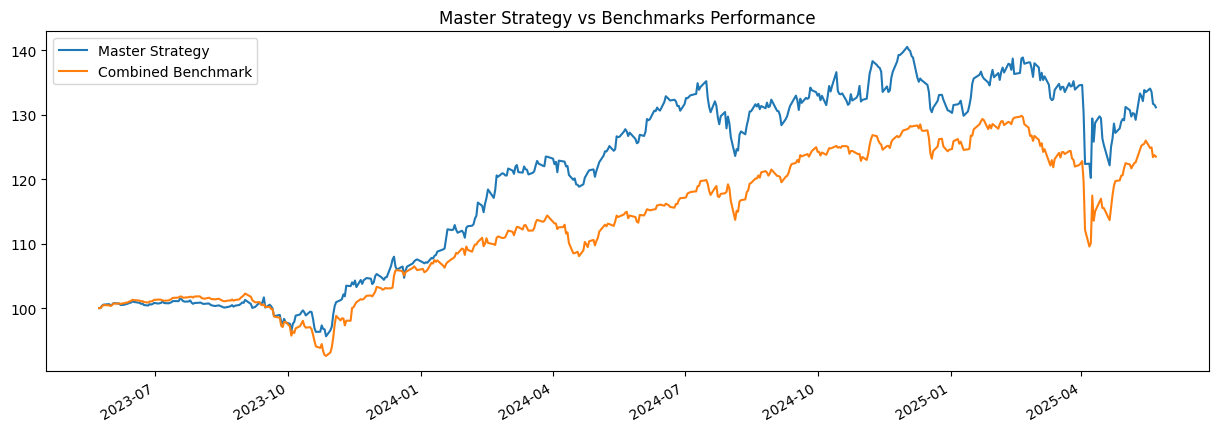

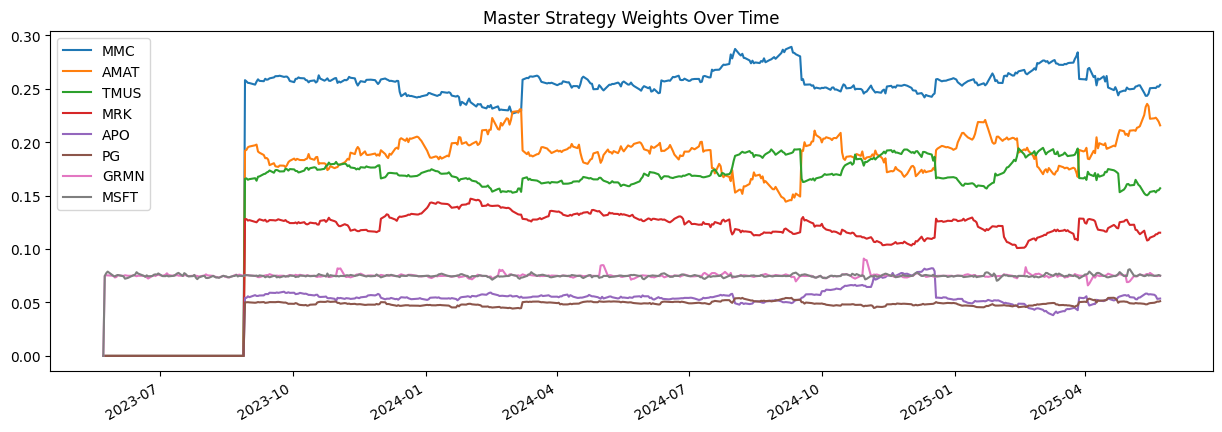

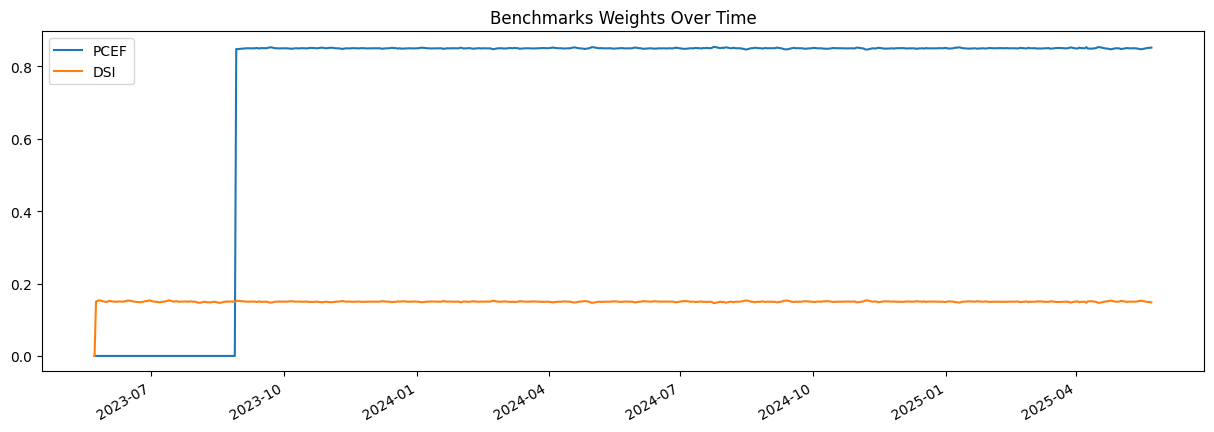

In [ ]:
res.display()

# res1.plot(title='Master Strategy Performance')
# res2.plot(title='Benchmarks Performance')
res.plot(title='Master Strategy vs Benchmarks Performance')

res1.plot_security_weights(title='Master Strategy Weights Over Time')
res2.plot_security_weights(title='Benchmarks Weights Over Time')

#### **Step 7: Transaction Costs Analysis**

In [16]:
# Get detailed transaction analysis
transactions = res.get_transactions()

print("="*60)
print("TRANSACTION ANALYSIS")
print("="*60)

# Total number of transactions
total_transactions = len(transactions)
print(f"Total Transactions: {total_transactions}")

# Transactions by security
transactions_by_security = transactions.groupby('Security').size().sort_values(ascending=False)
print(f"\nMost Traded Securities:")
print(transactions_by_security.head(10))

# Buy vs Sell transactions
buy_transactions = transactions[transactions['quantity'] > 0]
sell_transactions = transactions[transactions['quantity'] < 0]

print(f"\nBuy Transactions: {len(buy_transactions)}")
print(f"Sell Transactions: {len(sell_transactions)}")

# Transaction volume analysis
total_buy_volume = (buy_transactions['price'] * buy_transactions['quantity']).sum()
total_sell_volume = abs((sell_transactions['price'] * sell_transactions['quantity']).sum())

print(f"\nTotal Buy Volume: ${total_buy_volume:,.2f}")
print(f"Total Sell Volume: ${total_sell_volume:,.2f}")

# Monthly transaction frequency
transactions_monthly = transactions.reset_index().groupby(transactions.reset_index()['Date'].dt.to_period('M')).size()
print(f"\nAverage Transactions per Month: {transactions_monthly.mean():.1f}")

# Transaction costs estimation (assuming $1 per transaction)
estimated_transaction_costs = total_transactions * 1
print(f"Estimated Transaction Costs (@ $1/trade): ${estimated_transaction_costs:,.2f}")

TRANSACTION ANALYSIS
Total Transactions: 700

Most Traded Securities:
Security
GRMN    104
MSFT    100
MMC      92
AMAT     91
MRK      91
TMUS     88
APO      73
PG       61
dtype: int64

Buy Transactions: 331
Sell Transactions: 369

Total Buy Volume: $1,610,379.35
Total Sell Volume: $615,206.59

Average Transactions per Month: 28.0
Estimated Transaction Costs (@ $1/trade): $700.00
